In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Image segmentation with CamVid

In [3]:
cd drive/My\ Drive/

/content/drive/My Drive


In [4]:
cd idd20k_lite/

/content/drive/My Drive/idd20k_lite


In [5]:
ls

fast/  fast.zip  gtFine/  leftImg8bit/


In [0]:
ls merge_labels_mod/ | wc -l

1603


In [0]:
ls merge_images/ | wc -l

1604


In [0]:
ls merge_labels_mod/*__2* | wc -l

4


In [0]:
!unzip fast.zip

In [6]:
cd fast

/content/drive/My Drive/idd20k_lite/fast


In [0]:
mkdir instlabels_val/

In [0]:
!mv labels_val/*_inst* instlabels_val/

In [0]:
ls instlabels_train/ | wc -l

1403


In [0]:
mkdir merge_instlabels_mod

In [0]:
cd ../

/content/drive/My Drive/idd20k_lite/fast


In [0]:
!diff images_train labels_train

In [0]:
cp instlabels_val/* merge_instlabels/

In [0]:
rm merge_labels_mod/*

In [0]:
from PIL import Image

In [0]:
for x in os.listdir('merge_labels'):
    im = Image.open('merge_labels/'+x)
    pixelMap = im.load()
    for i in range(im.size[0]):
        for j in range(im.size[1]):
            if pixelMap[i,j]==255:
                pixelMap[i,j]=7
    im.save('merge_labels_mod/'+x)

In [0]:
rm images_train/*~* 

6

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
path = untar_data(URLs.CAMVID)
path.ls()

In [0]:
tr_path_lbl = 'labels_train'
val_path_lbl = 'labels_val'
tr_path_img = 'images_train'
val_path_img = 'images_val'

In [0]:
path_lbl='merge_labels_mod'
path_img='merge_images'

In [0]:
cd labels_train/

/content/drive/My Drive/idd20k_lite/fast/labels_train


In [0]:
# !find . -name '*' -exec bash -c ' mv $0 ${0/\label/image_label}' {} \;
!find . -name '*' -exec bash -c ' mv $0 ${0/\image_label/image}' {} \;

mv: '.' and './.' are the same file


In [0]:
cd ../

/content/drive/My Drive/idd20k_lite/fast


## Subset classes

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [10]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('merge_images/563753_image.jpg'),
 PosixPath('merge_images/564882_image.jpg'),
 PosixPath('merge_images/566200_image.jpg')]

In [11]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('merge_labels_mod/192933_image_label.png'),
 PosixPath('merge_labels_mod/193831_image_label.png'),
 PosixPath('merge_labels_mod/194242_image_label.png')]

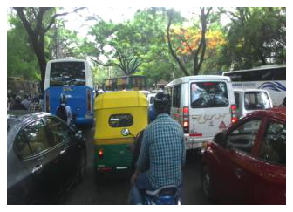

In [12]:
img_f = fnames[5]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl+'/'+f'{x.stem}_label.png'

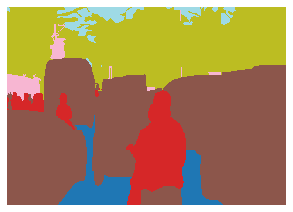

In [14]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [15]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([227, 320]), tensor([[[6, 6, 5,  ..., 5, 5, 5],
          [6, 6, 6,  ..., 5, 5, 5],
          [6, 6, 6,  ..., 5, 5, 5],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

In [16]:
np.unique(mask.data)

array([0, 2, 3, 4, 5, 6])

In [0]:
codes = np.array(['drivable', 'non-drivable', 'living-things', 'vehicle', 'road-side-objs', 'far-objects', 'sky', 'Void'])

## Datasets

In [19]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")
bs=4

using bs=8, have 16270MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(valid_pct=0.3)
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

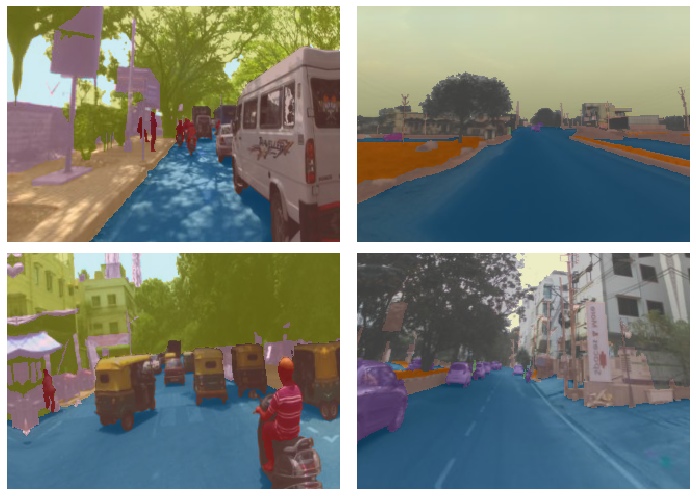

In [0]:
data.show_batch(2, figsize=(10,7))

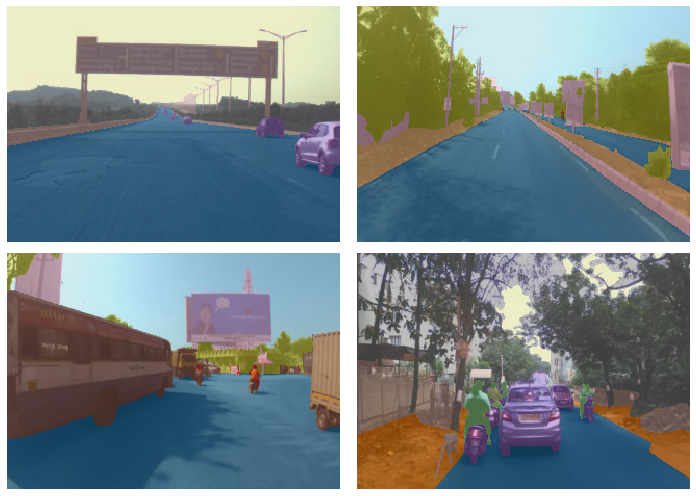

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc
# metrics=accuracy

In [0]:
metrics=dice

In [0]:
wd=1e-2

In [26]:
learn = unet_learner(data, models.resnet50, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


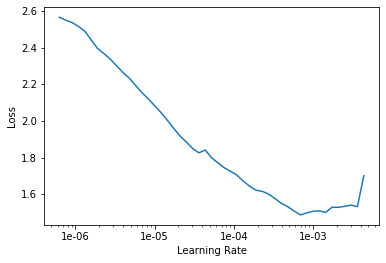

In [22]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-4

In [30]:
learn.fit_one_cycle(2, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc,time
0,0.420292,0.406328,0.852452,21:30
1,0.410192,0.381112,0.858080,21:29


In [34]:
learn.fit_one_cycle(1, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc,time
0,0.370034,0.366079,0.863692,21:26


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.summary()

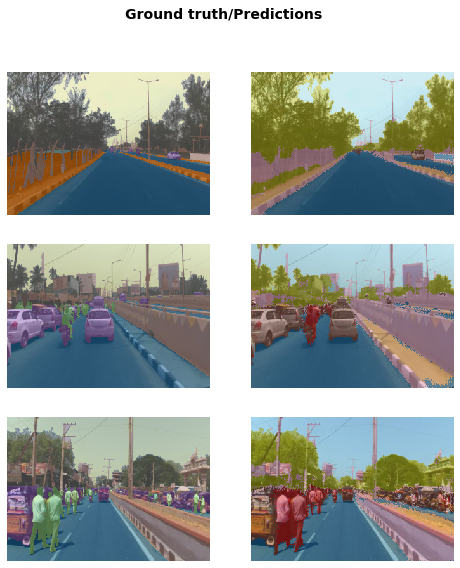

In [37]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(20, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc,time
0,0.300142,0.301037,0.885258,10:48
1,0.304827,0.302889,0.884639,10:47
2,0.311132,0.304110,0.884456,10:48
3,0.298210,0.309916,0.884655,10:48
4,0.295835,0.312086,0.883928,10:49
5,0.315951,0.327515,0.882814,10:50


In [35]:
learn.fit_one_cycle(20, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc,time
0,0.306286,0.303179,0.884176,10:47


In [0]:
learn.save('stage-2');

In [27]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (1123 items)
x: SegmentationItemList
Image (3, 227, 320),Image (3, 227, 320),Image (3, 227, 320),Image (3, 227, 320),Image (3, 227, 320)
y: SegmentationLabelList
ImageSegment (1, 227, 320),ImageSegment (1, 227, 320),ImageSegment (1, 227, 320),ImageSegment (1, 227, 320),ImageSegment (1, 227, 320)
Path: merge_images;

Valid: LabelList (480 items)
x: SegmentationItemList
Image (3, 227, 320),Image (3, 227, 320),Image (3, 227, 320),Image (3, 227, 320),Image (3, 227, 320)
y: SegmentationLabelList
ImageSegment (1, 227, 320),ImageSegment (1, 227, 320),ImageSegment (1, 227, 320),ImageSegment (1, 227, 320),ImageSegment (1, 227, 320)
Path: merge_images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPo

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [0]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


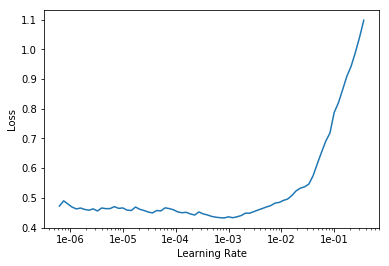

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

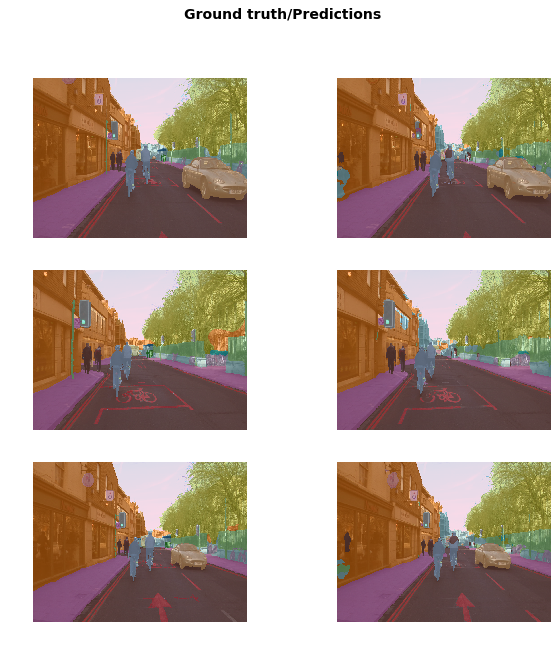

In [0]:
learn.show_results(rows=3, figsize=(10,10))

## fin

In [0]:
import os
import cv2

In [0]:
mkdir labels_test

In [0]:

for x in os.listdir('images_test'):
    img = open_image('/images_test/'+x)
    im_g=learn.predict(img)
    cv2.imwrite('labels_test'+x+'_label',(np.array(im_g[1][0])))